In [ ]:
#@title Install River (requires to restart runtime if in Colab)

!pip install -U numpy 
!pip install river
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 54.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Import libraries and packages

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

from river import stream
from river import drift
from river.base import drift_detector
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
from river import ensemble
from river import utils
from river import forest
from river import time_series
from river import neural_net as nn

from matplotlib import pyplot as plt, gridspec

##Load dataset and perform drift detection

In [3]:
#@title Load dataset (requires dataset file to be in current directory) and perform EDA

data = pd.read_csv('./Carelink 670G.csv', dtype={'sensorglucose':float}, parse_dates=[1]).drop(['subjectid'], axis=1)
print(data.describe())
print(f"Number of nulls = {data.isna().sum().sum()}")

       sensorglucose
count    3363.000000
mean      123.650312
std        37.529092
min        40.000000
25%        98.000000
50%       120.000000
75%       145.000000
max       248.000000
Number of nulls = 301


In [4]:
data = data.dropna()
data['target'] = data['sensorglucose'].shift(-6)
data = data.dropna().reset_index(drop=True)
data

<ipython-input-4-057b2c4150d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['sensorglucose'].shift(-6)


,timestamp,sensorglucose,target
0,2018-10-17 00:03:00,129.0,123.0
1,2018-10-17 00:08:00,129.0,122.0
2,2018-10-17 00:13:00,127.0,120.0
3,2018-10-17 00:18:00,126.0,119.0
4,2018-10-17 00:23:00,125.0,117.0
...,...,...,...
3352,2018-10-29 21:12:00,109.0,89.0
3353,2018-10-29 21:17:00,106.0,91.0
3354,2018-10-29 21:22:00,102.0,92.0
3355,2018-10-29 21:27:00,100.0,87.0


In [ ]:
#@title Drif detection

adwin = drift.ADWIN()
num_data_points = 1000
for i, val in data[:num_data_points].iterrows():
    _ = adwin.update(val[2])
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 63, input value: timestamp        2018-10-17 05:18:00
sensorglucose                   94.0
target                          95.0
Name: 63, dtype: object
Change detected at index 159, input value: timestamp        2018-10-17 13:18:00
sensorglucose                  159.0
target                         133.0
Name: 159, dtype: object
Change detected at index 191, input value: timestamp        2018-10-17 15:58:00
sensorglucose                   72.0
target                          86.0
Name: 191, dtype: object
Change detected at index 255, input value: timestamp        2018-10-17 21:18:00
sensorglucose                   72.0
target                          62.0
Name: 255, dtype: object
Change detected at index 351, input value: timestamp        2018-10-18 05:18:00
sensorglucose                  123.0
target                         122.0
Name: 351, dtype: object
Change detected at index 415, input value: timestamp        2018-10-18 13:30:00
sensorglucose              

In [ ]:
def plot_data(drifts=None, num_data_points=0):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1= plt.subplot(gs[0])
    ax1.grid()
    plt.xticks(rotation=90)
    ax1.plot(data[:num_data_points]['timestamp'].to_list(), data[:num_data_points]['target'].to_list(), label='Stream')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(data[:num_data_points]['timestamp'].to_list()[drift_detected], color='red')
    plt.show()

Change detected at index 311
Change detected at index 375
Change detected at index 503
Change detected at index 567
Change detected at index 695
Change detected at index 791
Change detected at index 823
Change detected at index 887
Change detected at index 951


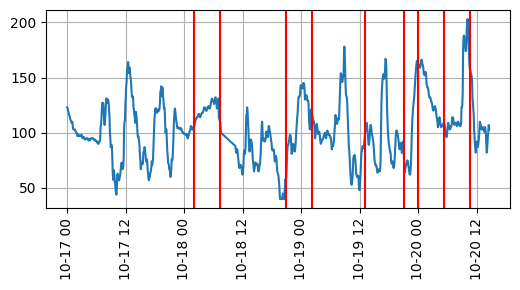

In [ ]:
#@title Plot drift detection

drifts = []
for i, val in data[:num_data_points].iterrows():
    adwin.update(val[2])   # Data is processed one sample at a time
    if adwin.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)


plot_data(drifts)

##Evaluate regressor models

In [ ]:
#@title Transform pandas dataframe to River compatible dataset

dataset = [(d, d['target']) for d in data.to_dict('records')]

for item, _ in dataset:
  item['timestamp'] = item['timestamp'].to_pydatetime()
  item.pop("target")

In [ ]:
def get_hour(x):
    x['hour'] = x['timestamp'].hour
    return x

In [ ]:
def evaluate_regressor(regressor):
  model = compose.Select('sensorglucose')

  model += (
      get_hour |
      feature_extraction.TargetAgg(by=['sensorglucose', 'hour'], how=stats.Mean())
  )

  model |= preprocessing.StandardScaler()
  model |= regressor

  metric = metrics.MAE()

  evaluate.progressive_val_score(
      dataset=dataset,
      model=model.clone(),
      metric=metrics.MAE(),
      moment='timestamp',
      delay=timedelta(minutes=30),
      print_every=400
  )

In [ ]:
#@title Linear Regression with SGD optimizer

evaluate_model(linear_model.LinearRegression(optimizer=optim.SGD(0.01)))

[400] MAE: 24.275581
[800] MAE: 20.334288
[1,200] MAE: 18.034422
[1,600] MAE: 18.524822
[2,000] MAE: 18.273929
[2,400] MAE: 18.103715
[2,800] MAE: 17.627461
[3,200] MAE: 17.451389
[3,357] MAE: 17.423879


MAE: 17.423879

In [ ]:
#@title Linear Regression with ADAM optimizer

evaluate_model(linear_model.LinearRegression(optimizer=optim.Adam(0.1)))

[400] MAE: 28.428281
[800] MAE: 22.634895
[1,200] MAE: 19.761412
[1,600] MAE: 19.792375
[2,000] MAE: 19.161169
[2,400] MAE: 18.661124
[2,800] MAE: 18.044225
[3,200] MAE: 17.787552
[3,357] MAE: 17.696246


MAE: 17.696246

In [ ]:
#@title Bagging Regressor with Linear Regressors

evaluate_model(ensemble.BaggingRegressor(
    model=linear_model.LinearRegression(optimizer=optim.Adam(0.1)), 
    n_models=10
    )
)

[400] MAE: 28.514782
[800] MAE: 22.711867
[1,200] MAE: 19.795759
[1,600] MAE: 19.81571
[2,000] MAE: 19.11759
[2,400] MAE: 18.62514
[2,800] MAE: 18.03272
[3,200] MAE: 17.780423
[3,357] MAE: 17.689655


MAE: 17.689655

In [ ]:
#@title ARFRegressor

evaluate_model(forest.ARFRegressor(
    n_models= 5,
    drift_detector = drift.ADWIN(0.005)
    )
)

[400] MAE: 15.970267
[800] MAE: 16.095201
[1,200] MAE: 16.186843
[1,600] MAE: 17.487028
[2,000] MAE: 17.152676
[2,400] MAE: 17.064064
[2,800] MAE: 16.649993
[3,200] MAE: 16.550878
[3,357] MAE: 16.540128


MAE: 16.540128

In [ ]:
#@title MLPRegressor

evaluate_model(nn.MLPRegressor(
    hidden_dims=(10,20,5),
    activations=(
        nn.activations.ReLU,
        nn.activations.ReLU,
        nn.activations.ReLU,
        nn.activations.ReLU,
        nn.activations.Identity
        ),
    optimizer=optim.Adam(0.01)
    )
)

[400] MAE: 44.200304
[800] MAE: 35.107634
[1,200] MAE: 30.517733
[1,600] MAE: 32.744659
[2,000] MAE: 32.24873
[2,400] MAE: 32.475717
[2,800] MAE: 32.594601
[3,200] MAE: 31.482164
[3,357] MAE: 31.659127


MAE: 31.659127